<h3>Objective</h3>
As discussed last time, my objective here is to do the following three things:
<ol>
<li>Look at doing k-fold cross validation
<li>Look at doing grid search to find better parameters
<li>Look at misclassified points to see patters for where the model is going wrong
</ol>

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

In [30]:
Training_data = pd.read_json("../input/whatscooking/train.json")
Training_data['str_ingredients'] = Training_data.ingredients.apply(lambda x: ','.join(y for y in x))

In [31]:
def describe_dataset(dataset, dataset_name="given"):
    display(dataset.describe())
    cuisines = dataset.groupby("cuisine").count().sort("id", ascending=False)
    display(cuisines.head())
    i = range(cuisines.count().ingredients)
    plt.bar(i, cuisines.ingredients, label='Number of recipes in {} dataset'.format(dataset_name))
    plt.ylabel('total number of recipes')
    plt.title('Number of recipes by type of cuisine')
    plt.xticks(i, cuisines.index.values, rotation='vertical')
    plt.legend(loc='upper right')
    plt.show()

,id
count,39774.000000
mean,24849.536959
std,14360.035505
min,0.000000
25%,12398.250000
50%,24887.000000
75%,37328.500000
max,49717.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,7838,7838,7838
mexican,6438,6438,6438
southern_us,4320,4320,4320
indian,3003,3003,3003
chinese,2673,2673,2673


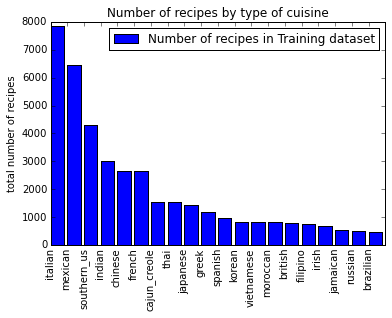

In [32]:
describe_dataset(Training_data, "Training");

In [33]:
from sklearn.cross_validation import train_test_split
train, test = train_test_split(Training_data, test_size = 0.2)

,id
count,31819.000000
mean,24789.064898
std,14355.934771
min,0.000000
25%,12324.500000
50%,24800.000000
75%,37224.500000
max,49717.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,6261,6261,6261
mexican,5134,5134,5134
southern_us,3473,3473,3473
indian,2411,2411,2411
chinese,2121,2121,2121


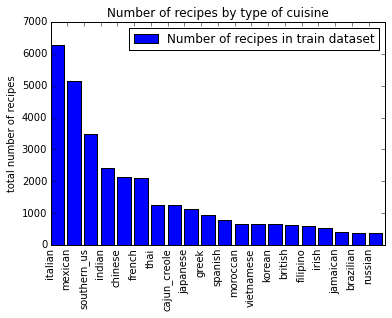

,id
count,7955.000000
mean,25091.417599
std,14374.785511
min,4.000000
25%,12730.500000
50%,25271.000000
75%,37746.500000
max,49716.000000


,id,ingredients,str_ingredients
cuisine,,,
italian,1577,1577,1577
mexican,1304,1304,1304
southern_us,847,847,847
indian,592,592,592
chinese,552,552,552


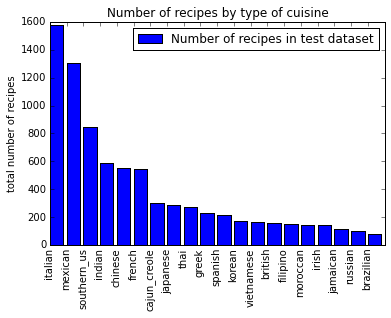

In [34]:
describe_dataset(train, "train");
describe_dataset(test, "test");

In [35]:
import itertools
grouped_ingredients = itertools.groupby(sorted(list(itertools.chain.from_iterable(Training_data.ingredients))))
ingredient_counts = {key:len(list(group)) for key, group in grouped_ingredients}
global_pantry = pd.DataFrame.from_dict(ingredient_counts, orient='index')
global_pantry.columns = ['num_recipes']
display(global_pantry.count())
global_pantry.head()

num_recipes    6714
dtype: int64

,num_recipes
low-sodium fat-free chicken broth,22
sweetened coconut,3
baking chocolate,3
egg roll wrappers,57
bottled low sodium salsa,1


In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(sublinear_tf=True, vocabulary=global_pantry.index.values)
X_train = vectorizer.fit_transform(train.str_ingredients)
feature_names = vectorizer.get_feature_names()
feature_names = np.asarray(feature_names);

In [37]:
X_test = vectorizer.transform(test.str_ingredients)
y_train = train.cuisine
y_test = test.cuisine

In [38]:
from sklearn.utils.extmath import density
from sklearn import metrics
from time import time

def benchmark(name, classifier, verbose=False):
    print "Training: {}".format(classifier)
    
    t0 = time()
    classifier.fit(X_train, y_train)
    train_time = time() - t0
    
    t0 = time()
    predictions = classifier.predict(X_test)
    test_time = time() - t0
    
    score = metrics.accuracy_score(y_test, predictions)
    
    if verbose and hasattr(classifier, 'coef_'):
        print "Dimensionality: {}".format(classifier.coef_.shape[1])
        print "Density: {}".format(density(classifier.coef_))

        print "top10 features for each category:"
        for i, category in enumerate(classifier.classes_):
            top10 = np.argsort(classifier.coef_[i])[-10:]
            print("%s: %s" % (category, " ".join(feature_names[top10])))

        print "classification report:"
        print metrics.classification_report(y_test, predictions)

        print "confusion matrix:"
        print metrics.confusion_matrix(y_test, predictions)
    
    print "Accuracy: {}, Train time: {}, Test time: {}".format(score, train_time, test_time)
    return name, score, train_time, test_time

In [40]:
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
classifiers = [
    ("SVC_rbf", SVC(kernel='rbf')),
    ("RandomForestClassifier_250", RandomForestClassifier(n_estimators=250)),
    ("LinearSVC_L2", LinearSVC(loss='squared_hinge', penalty='l2', dual=False, tol=1e-3)),
    ("SVC_linear", SVC(kernel='linear')),
    ("Pipeline_LinearSVC_L2_Linear", Pipeline([
        ('feature_selection', LinearSVC(penalty="l2", dual=False, tol=1e-3)),
        ('classification', LinearSVC())
    ])),
]
results = []
for name, classifier in classifiers:
    results.append(benchmark(name, classifier))

Training: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Accuracy: 0.198240100566, Train time: 301.991544008, Test time: 54.1577091217
Training: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Accuracy: 0.732243871779, Train time: 272.567488194, Test time: 5.79733896255
Training: LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.001,
     verbose=0)
Accuracy: 0.733123821496, Train time: 6.21387219429,

In [41]:
results

[('SVC_rbf', 0.19824010056568195, 301.991544008255, 54.1577091217041),
 ('RandomForestClassifier_250',
  0.7322438717787555,
  272.56748819351196,
  5.797338962554932),
 ('LinearSVC_L2',
  0.73312382149591448,
  6.213872194290161,
  0.007609844207763672),
 ('SVC_linear', 0.73689503456945316, 95.15041184425354, 21.405669927597046),
 ('Pipeline_LinearSVC_L2_Linear',
  0.73312382149591448,
  6.614709854125977,
  0.012554168701171875)]

In [42]:
sorted_results = sorted(results, key=lambda x: x[1])
sorted_results

[('SVC_rbf', 0.19824010056568195, 301.991544008255, 54.1577091217041),
 ('RandomForestClassifier_250',
  0.7322438717787555,
  272.56748819351196,
  5.797338962554932),
 ('LinearSVC_L2',
  0.73312382149591448,
  6.213872194290161,
  0.007609844207763672),
 ('Pipeline_LinearSVC_L2_Linear',
  0.73312382149591448,
  6.614709854125977,
  0.012554168701171875),
 ('SVC_linear', 0.73689503456945316, 95.15041184425354, 21.405669927597046)]

In [43]:
rearranged_results = [[x[i] for x in sorted_results] for i in range(4)]
rearranged_results

[['SVC_rbf',
  'RandomForestClassifier_250',
  'LinearSVC_L2',
  'Pipeline_LinearSVC_L2_Linear',
  'SVC_linear'],
 [0.19824010056568195,
  0.7322438717787555,
  0.73312382149591448,
  0.73312382149591448,
  0.73689503456945316],
 [301.991544008255,
  272.56748819351196,
  6.213872194290161,
  6.614709854125977,
  95.15041184425354],
 [54.1577091217041,
  5.797338962554932,
  0.007609844207763672,
  0.012554168701171875,
  21.405669927597046]]

In [44]:
indices = np.arange(len(results))
clf_names, score, train_time, test_time = rearranged_results

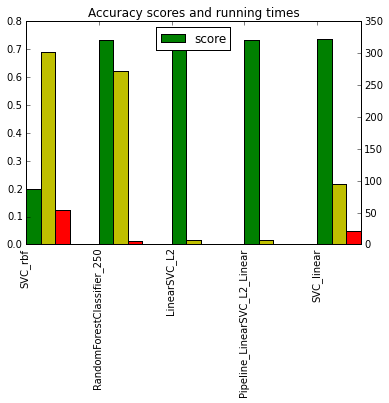

In [45]:
plt.title("Accuracy scores and running times")
width = 0.2
plt.bar(indices, score, width, label="score", color='g')
plt.legend(loc='upper center')
plt.xticks(indices, clf_names, rotation='vertical')
plt.twinx()
plt.bar(indices+width, train_time, width, label="train_time", color='y')
plt.bar(indices+(2*width), test_time, width, label="test_time", color='r')
plt.show()